# The Monty Hall Problem, Simulated.
## By John 'IVYsalmon' Salmon

#### Introduction.
My first introduction to this problem was from the movie 21 where the main character was challenged with it by a statistics professor. The movie was certainly not my favorite but ever since that scene I was interested in the solution and tried to figure it out with out looking up the answer. By nature the problem is a veridical paradox meaning that the solution is counterintuitive and difficult to understand. I definitely encountered this as I was reasoning through it in my head.

The problem goes like this:
You are invited to a game show with a simple set of rules. There are three doors on the stage, behind two of them are goats and behind the last door is a car. If you pick the door with the car you win, if you pick one of the goats you lose. You don't know which items are behind which doors, and there is no possible way to figure it out. It is entirely a game of chance. At the start of the game the host invites you to pick a door. Once you have locked in your answer the host then reveals one of the other two doors. The door they reveal will always have a goat behind it, they will never ruin the game by revealing the car and putting you in an unwinnable situation. After they reveal a door you are offered the chance to swap from the initial door you selected to the remaining door. The question behind the problem is, **Is it better to swap doors or keep your original selection?***

Reasoning our way through it, we can recognize that our original selection has a 1/3 chance of winning as 1 of the 3 doors has the car behind it. Once the host reveals one of the goats the chances of winning go down to 1/2 because now one of the two doors has the goat behind it. So surely there is no difference between swapping and staying right?

#### Setup

In [3]:
%pip install -q pandas matplotlib seaborn tqdm Pillow IPython jupyter-client<8 pyzmq<25


Note: you may need to restart the kernel to use updated packages.


The system cannot find the file specified.


In [1]:
import random
import concurrent.futures
from tqdm import tqdm
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

For this simulation there are a few required libraries that don't come with python.
pandas - used for its dataframe management allowing for easier management and modelling of results
matplotlib - graphing
seaborn - graphing
tqdm - creates a cool progress bar for reassurance that the program is actually doing something (1 billion results takes a long time...)

In [2]:
doorOptions = ['goat', 'goat', 'car']
strategy = ['stay', 'swap']

NUMTRIALS = int(1e6)  # Reduced for demonstration purposes
CHUNK_SIZE = int(NUMTRIALS / 100) # Number of tasks to submit at once
NUM_CORES = os.cpu_count()
results = []

def run_trial(trial_num):
    doors = doorOptions.copy()
    strat = random.choice(strategy)
    if strat == 'stay':
        initial_choice = random.choice(doors)  # choose door
        doors.remove(initial_choice)  # remove chosen door
        doors.remove('goat')  # Monty Hall reveals a goat
        remaining = doors[0]  # the remaining door
        if remaining == 'car':  # the remaining door is a car which was not chosen
            outcome = 'Lose'
        else:  # the remaining choice was a goat so the initial choice was the car
            outcome = 'Win'
    elif strat == 'swap':
        initial_choice = random.choice(doors)  # choose door
        doors.remove('goat')  # Monty Hall reveals a goat
        doors.remove(initial_choice)  # remove the initial choice, the remaining item is our new choice
        remaining = doors[0]
        if remaining == 'car':  # choice is the car
            outcome = 'Win'
        else:  # choice is the goat
            outcome = 'Lose'
    else:
        raise ValueError('Invalid Strategy')

    trial_info = {
        'initial_choice': initial_choice,
        'remaining': remaining,
        'outcome': outcome,
        'strategy': strat
    }
    return trial_info

# Use ThreadPoolExecutor to run trials in parallel
with concurrent.futures.ThreadPoolExecutor(max_workers = NUM_CORES) as executor:  # Adjust max_workers as needed
    print('Starting simulation with', NUMTRIALS, 'trials')
    with open('MontyHallResults.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['strategy', 'initial_choice', 'remaining', 'outcome'])  # Write header

        for i in tqdm(range(0, NUMTRIALS, CHUNK_SIZE)):
            chunk_futures = [executor.submit(run_trial, j) for j in range(i, min(i + CHUNK_SIZE, NUMTRIALS))]
            chunk_results = []
            for future in concurrent.futures.as_completed(chunk_futures):
                result = future.result()
                chunk_results.append([result['strategy'], result['initial_choice'], result['remaining'], result['outcome']])
            writer.writerows(chunk_results)  # Write results in batches

print('Successfully simulated', NUMTRIALS, 'trials')

Starting simulation with 1000000 trials


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:36<00:00,  2.71it/s]

Successfully simulated 1000000 trials


The code above looks complex but it is fairly simple in nature. Each trial starts with the process of randomly selecting the strategy for that round, either to stay with the initially selected door is revealed or swapping to the other remaining door after a goat is revealed. Next the initial random choice of a door is selected. This is done using the random choice function from the random library. Once a door is selected one of the goats is removed from the set which represents the revealing of one of the goat doors. Based on the strategy chosen, the initial choice is either removed before or after the reveal of the goat. Based on the remaining item the win or loss is evaluated. If the strategy was to stay on the door and the remaining choice is the car then that is a loss because we did not chose the car and the car was the remaining option. For the swap strategy the logic is reversed, the remaining item is our selection so if the car remains we win because it was our selection.

What adds most of the bulk to the code is the multithreading setup that allows a computer cpu to run as many trials as there are cores at the same time and log the results, at small trial numbers such as 1000 there isn't a big difference in runtime, however the goal is to simulate 1 million or more trials, at that number being able to run 12 times as many trials at the same time makes a big difference. 

The final note is the output of the results as a csv, once again at fewer trials this isn't strictly necessary. However, storing the results of 1 million or more trials in memory can take a quite a bit of space. By writing the results to a file on disc this space is memory is saved and when processing the results we can either read the file into memory then or process it line by line to preserve memory space.

#### Plot Results

Animation size has reached 20978527 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


KeyboardInterrupt: 

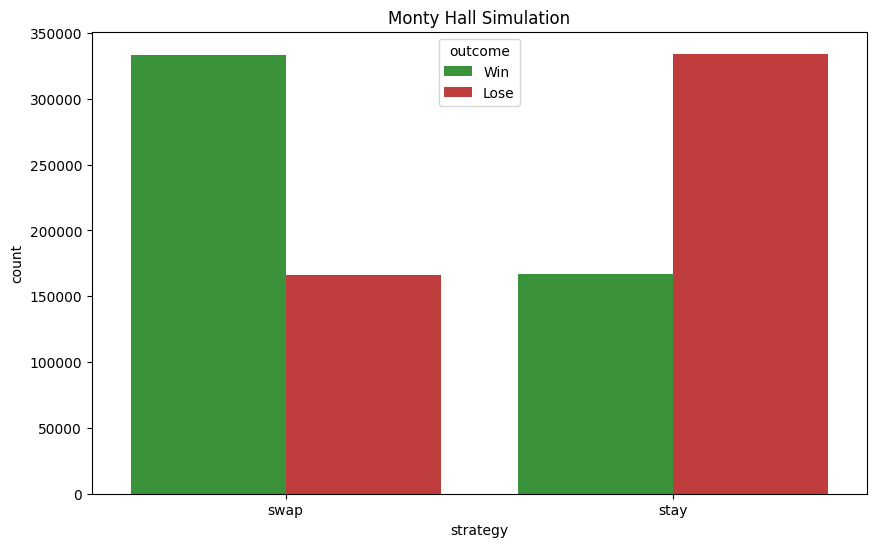

In [2]:
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML

# Load the data
mh = pd.read_csv('MontyHallResults.csv')
swapped = mh[mh['strategy'] == 'swap']
stayed = mh[mh['strategy'] == 'stay']

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Custom colors
colors = ['#2ca02c', '#d62728']

# Initialize the plot
def init():
    sns.countplot(x='strategy', data=mh, hue='outcome', ax=ax, palette=colors)
    ax.set_title('Monty Hall Simulation')
    return ax,

# Update the plot for each frame
def update(frame):
    ax.clear()
    sns.countplot(x='strategy', data=mh.iloc[:frame*100000], hue='outcome', ax=ax, palette=colors)
    ax.set_title('Monty Hall Simulation')
    return ax,

# Create the animation
ani = FuncAnimation(fig, update, frames=range(1, len(mh)//100000 + 1), init_func=init, interval=200, repeat=False)

# Save the animation as a GIF
ani.save('MontyHallSimulation.gif', writer=PillowWriter(fps=60))

# Display the animation in the notebook
HTML(ani.to_jshtml())

As we can see from the animated plot, there is an advantage to swapping after the first goat is revealed. This is because of the presence of new information. As I understand it when you are making your initial choice it is 1 in 3 whether you select the goat or the car correctly. Our intuition suggests that once a door is revealed to be a goat that chance goes down to 1 in 2 because there are two doors remaining one of which must be the car and the other is the remaining goat. However, if you think about it if you remain with the original guess it is still a 1/3 chance, you made the selection when it was 1/3 and the revealed door doesn't change anything. By changing your selection once the goat is revealed you are truly creating a situation where it is 1 in 2. By acting on the new information you can change the odds. And this is reflected in our graph. There is a clear difference performance between the switch and stay strategy.